In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from numpy import meshgrid
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.autograd import gradcheck
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import shift
from math import sqrt
from scipy.sparse import diags
from scipy.linalg import cholesky

import os
inpath = "./data/Wildfire/Poly/input/"   # Path for the input data
impath = "./data/Wildfire/Poly/mac/"
immpath = "./plots/Wildfire/Poly/mac/"
os.makedirs(impath, exist_ok=True)
os.makedirs(immpath, exist_ok=True)

# 1D Wildlandfire example

In [2]:
Q_wf = np.load(inpath + 'SnapShotMatrix558.49.npy', allow_pickle=True)
t = np.load(inpath + 'Time.npy', allow_pickle=True)
x_grid = np.load(inpath + '1D_Grid.npy', allow_pickle=True)
x = x_grid[0]
T = Q_wf[:len(x), :]
seed = 133

In [3]:
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
Q = torch.tensor(T/T.max())

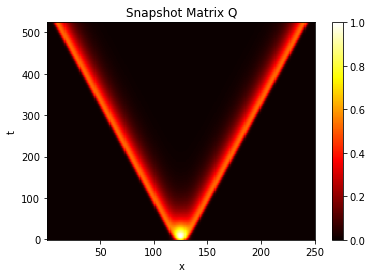

In [5]:
Nx = len(x)
Nt = len(t)
xx, tt = np.meshgrid(x, t)


plt.pcolormesh(xx.T, tt.T, Q, cmap='hot')
plt.colorbar()
plt.xlabel("x")
plt.ylabel("t")
plt.title('Snapshot Matrix Q')
plt.show()

## Define inputs

In [6]:
inputs = np.stack([x.repeat(Nt), np.tile(t, Nx)], axis=1)
inputs_tensor = torch.tensor(inputs, dtype=torch.float32)

## Define a model

In [7]:
class NuclearNormAutograd(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input_matrix):
        ctx.save_for_backward(input_matrix)
        return torch.linalg.matrix_norm(input_matrix, ord="nuc")

    @staticmethod
    def backward(ctx, grad_output):
        input_matrix, = ctx.saved_tensors
        u, s, v = torch.svd(input_matrix, some=False)
        rank = torch.sum(s > 0).item()
        dtype = input_matrix.dtype
        eye_approx = torch.diag((s > 0).to(dtype)[:rank])
        grad_input = torch.matmul(torch.matmul(u[:, :rank], eye_approx), v[:, :rank].t())
        return grad_input * grad_output.unsqueeze(-1).unsqueeze(-1)

In [8]:
class ShapeShiftNet(nn.Module):
    def __init__(self, p_init_coeffs1, p_init_coeffs2, p_init_coeffs3):
        super(ShapeShiftNet, self).__init__()
        
        self.alphas1 = nn.ParameterList(
            [nn.Parameter(torch.tensor([coeff], dtype=torch.float32), requires_grad=True) for coeff in p_init_coeffs1]
        )
        self.alphas2 = nn.ParameterList(
            [nn.Parameter(torch.tensor([coeff], dtype=torch.float32), requires_grad=True) for coeff in p_init_coeffs2]
        )
        self.alphas3 = nn.ParameterList(
            [nn.Parameter(torch.tensor([coeff], dtype=torch.float32), requires_grad=True) for coeff in p_init_coeffs3]
        )
        
        self.elu = nn.ELU()
        
        # Subnetwork for f^1
        self.f1_fc1 = nn.Linear(2, 5)
        self.f1_fc2 = nn.Linear(5, 10)
        self.f1_fc3 = nn.Linear(10, 5)
        self.f1_fc4 = nn.Linear(5, 1)
        
        # Subnetwork for f^2
        self.f2_fc1 = nn.Linear(2, 5)
        self.f2_fc2 = nn.Linear(5, 10)
        self.f2_fc3 = nn.Linear(10, 5)
        self.f2_fc4 = nn.Linear(5, 1)
        
        # Subnetwork for f^3
        self.f3_fc1 = nn.Linear(2, 5)
        self.f3_fc2 = nn.Linear(5, 10)
        self.f3_fc3 = nn.Linear(10, 5)
        self.f3_fc4 = nn.Linear(5, 1)
        
        
    def forward(self, x, t):
        # Pathway for f^1 and shift^1
        shift1 = sum([coeff * t**(1-i) for i, coeff in enumerate(self.alphas1)])
        
        x_shifted1 = x + shift1
        f1 = self.elu(self.f1_fc1(torch.cat((x_shifted1, t), dim=1)))
        f1 = self.elu(self.f1_fc2(f1))
        f1 = self.elu(self.f1_fc3(f1))
        f1 = self.f1_fc4(f1)
        
        f1_without_shift = self.elu(self.f1_fc1(torch.cat((x, t), dim=1)))
        f1_without_shift = self.elu(self.f1_fc2(f1_without_shift))
        f1_without_shift = self.elu(self.f1_fc3(f1_without_shift))
        f1_without_shift = self.f1_fc4(f1_without_shift)
        
        
        # Pathway for f^2 and shift^2
        shift2 = sum([coeff * t**(1-i) for i, coeff in enumerate(self.alphas2)])
        
        x_shifted2 = x + shift2
        f2 = self.elu(self.f2_fc1(torch.cat((x_shifted2, t), dim=1)))
        f2 = self.elu(self.f2_fc2(f2))
        f2 = self.elu(self.f2_fc3(f2))
        f2 = self.f2_fc4(f2)
        
        f2_without_shift = self.elu(self.f2_fc1(torch.cat((x, t), dim=1)))
        f2_without_shift = self.elu(self.f2_fc2(f2_without_shift))
        f2_without_shift = self.elu(self.f2_fc3(f2_without_shift))
        f2_without_shift = self.f2_fc4(f2_without_shift)
        
        
        # Pathway for f^3 and shift^3      
        shift3 = sum([coeff * t**(1-i) for i, coeff in enumerate(self.alphas3)])
        
        x_shifted3 = x + shift3
        f3 = self.elu(self.f3_fc1(torch.cat((x_shifted3, t), dim=1)))
        f3 = self.elu(self.f3_fc2(f3))
        f3 = self.elu(self.f3_fc3(f3))
        f3 = self.f3_fc4(f3)
        
        f3_without_shift = self.elu(self.f3_fc1(torch.cat((x, t), dim=1)))
        f3_without_shift = self.elu(self.f3_fc2(f3_without_shift))
        f3_without_shift = self.elu(self.f3_fc3(f3_without_shift))
        f3_without_shift = self.f3_fc4(f3_without_shift)
        
        return f1, f2, f3, f1_without_shift, f2_without_shift, f3_without_shift


In [9]:
def save_fig(filepath, figure=None, **kwargs):
    import tikzplotlib
    import os
    import matplotlib.pyplot as plt

    ## split extension
    fpath = os.path.splitext(filepath)[0]
    ## get figure handle
    if figure is None:
        figure = plt.gcf()
    figure.savefig(fpath + ".png", dpi=300, transparent=True)
    tikzplotlib.save(
        figure=figure,
        filepath=fpath + ".tex",
        axis_height='\\figureheight',
        axis_width='\\figurewidth',
        override_externals=True,
        **kwargs
    )

In [10]:
init_coefficients1 = [1, -1]
init_coefficients2 = [0, 0]
init_coefficients3 = [-1, 1]

In [11]:
model = ShapeShiftNet(init_coefficients1, init_coefficients2, init_coefficients3)

pretrained_load = True
if pretrained_load:
    state_dict_original = torch.load("./data/Crossing_waves/Poly/seed=54/Crossing_waves.pth")
    state_dict_new = model.state_dict()
    
    for name, param in state_dict_original.items():
        if name in state_dict_new:
            state_dict_new[name].copy_(param)  


    state_dict_new['alphas1.0'] = torch.tensor([1.5], dtype=torch.float32)  # state_dict_original['alphas2.0']
    state_dict_new['alphas1.1'] = torch.tensor([-1], dtype=torch.float32)   # state_dict_original['alphas2.1']
    state_dict_new['alphas2.0'] = torch.tensor([0], dtype=torch.float32)   # -state_dict_original['alphas2.0']
    state_dict_new['alphas2.1'] = torch.tensor([0], dtype=torch.float32)  # -state_dict_original['alphas2.1']
    state_dict_new['alphas3.0'] = torch.tensor([-1.5], dtype=torch.float32)   # -state_dict_original['alphas2.0']
    state_dict_new['alphas3.1'] = torch.tensor([1], dtype=torch.float32)  # -state_dict_original['alphas2.1']

    
#     state_dict_new['f1_fc1.weight'] = state_dict_original['f1_fc1.weight']
#     state_dict_new['f1_fc1.bias'] = state_dict_original['f1_fc1.bias']
#     state_dict_new['f1_fc2.weight'] = state_dict_original['f1_fc2.weight']
#     state_dict_new['f1_fc2.bias'] = state_dict_original['f1_fc2.bias']
#     state_dict_new['f1_fc3.weight'] = state_dict_original['f1_fc3.weight']
#     state_dict_new['f1_fc3.bias'] = state_dict_original['f1_fc3.bias']
#     state_dict_new['f1_fc4.weight'] = state_dict_original['f1_fc4.weight']
#     state_dict_new['f1_fc4.bias'] = state_dict_original['f1_fc4.bias']
    
#     state_dict_new['f2_fc1.weight'] = state_dict_original['f2_fc1.weight']
#     state_dict_new['f2_fc1.bias'] = state_dict_original['f2_fc1.bias']
#     state_dict_new['f2_fc2.weight'] = state_dict_original['f2_fc2.weight']
#     state_dict_new['f2_fc2.bias'] = state_dict_original['f2_fc2.bias']
#     state_dict_new['f2_fc3.weight'] = state_dict_original['f2_fc3.weight']
#     state_dict_new['f2_fc3.bias'] = state_dict_original['f2_fc3.bias']
#     state_dict_new['f2_fc4.weight'] = state_dict_original['f2_fc4.weight']
#     state_dict_new['f2_fc4.bias'] = state_dict_original['f2_fc4.bias']
    
#     state_dict_new['f3_fc1.weight'] = state_dict_original['f3_fc1.weight']
#     state_dict_new['f3_fc1.bias'] = state_dict_original['f3_fc1.bias']
#     state_dict_new['f3_fc2.weight'] = state_dict_original['f3_fc2.weight']
#     state_dict_new['f3_fc2.bias'] = state_dict_original['f3_fc2.bias']
#     state_dict_new['f3_fc3.weight'] = state_dict_original['f3_fc3.weight']
#     state_dict_new['f3_fc3.bias'] = state_dict_original['f3_fc3.bias']
#     state_dict_new['f3_fc4.weight'] = state_dict_original['f3_fc4.weight']
#     state_dict_new['f3_fc4.bias'] = state_dict_original['f3_fc4.bias']





    state_dict_new['f1_fc1.weight'] = state_dict_original['f2_fc1.weight']
    state_dict_new['f1_fc1.bias'] = state_dict_original['f2_fc1.bias']
    state_dict_new['f1_fc2.weight'] = state_dict_original['f2_fc2.weight']
    state_dict_new['f1_fc2.bias'] = state_dict_original['f2_fc2.bias']
    state_dict_new['f1_fc3.weight'] = state_dict_original['f2_fc3.weight']
    state_dict_new['f1_fc3.bias'] = state_dict_original['f2_fc3.bias']
    state_dict_new['f1_fc4.weight'] = state_dict_original['f2_fc4.weight']
    state_dict_new['f1_fc4.bias'] = state_dict_original['f2_fc4.bias']
    
    state_dict_new['f2_fc1.weight'] = state_dict_original['f2_fc1.weight']
    state_dict_new['f2_fc1.bias'] = state_dict_original['f2_fc1.bias']
    state_dict_new['f2_fc2.weight'] = state_dict_original['f2_fc2.weight']
    state_dict_new['f2_fc2.bias'] = state_dict_original['f2_fc2.bias']
    state_dict_new['f2_fc3.weight'] = state_dict_original['f2_fc3.weight']
    state_dict_new['f2_fc3.bias'] = state_dict_original['f2_fc3.bias']
    state_dict_new['f2_fc4.weight'] = state_dict_original['f2_fc4.weight']
    state_dict_new['f2_fc4.bias'] = state_dict_original['f2_fc4.bias']
    
    state_dict_new['f3_fc1.weight'] = state_dict_original['f2_fc1.weight']
    state_dict_new['f3_fc1.bias'] = state_dict_original['f2_fc1.bias']
    state_dict_new['f3_fc2.weight'] = state_dict_original['f2_fc2.weight']
    state_dict_new['f3_fc2.bias'] = state_dict_original['f2_fc2.bias']
    state_dict_new['f3_fc3.weight'] = state_dict_original['f2_fc3.weight']
    state_dict_new['f3_fc3.bias'] = state_dict_original['f2_fc3.bias']
    state_dict_new['f3_fc4.weight'] = state_dict_original['f2_fc4.weight']
    state_dict_new['f3_fc4.bias'] = state_dict_original['f2_fc4.bias']
    
    model.load_state_dict(state_dict_new, strict=False)
    
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [12]:
def TV(Q, Nx, Nt):
    
    tv_h = torch.pow(Q[:, 1:]-Q[:, :-1], 2).sum()

    return (tv_h)/(Nx * Nt)

In [ ]:
num_epochs = 100000
lambda_k = 0.1
lambda_TV = 0.5

for epoch in range(num_epochs + 1):
    x_NN, t_NN = inputs_tensor[:, 0:1], inputs_tensor[:, 1:2]
    
    optimizer.zero_grad()
    f1_full, f2_full, f3_full, f1_full_nos, f2_full_nos, f3_full_nos = model(x_NN,t_NN)
    
    frobenius_loss = torch.norm(Q - f1_full.view(Nx, Nt) - f2_full.view(Nx, Nt) - f3_full.view(Nx, Nt),  'fro') ** 2
    
    nuclear_loss_q1 = NuclearNormAutograd.apply(f1_full_nos.view(Nx, Nt)) 
    nuclear_loss_q2 = NuclearNormAutograd.apply(f2_full_nos.view(Nx, Nt))
    nuclear_loss_q3 = NuclearNormAutograd.apply(f3_full_nos.view(Nx, Nt))
    nuclear_loss = lambda_k * (nuclear_loss_q1 + nuclear_loss_q2 + nuclear_loss_q3)
    
    TV_loss = lambda_TV * (TV(f1_full_nos.view(Nx, Nt), Nx, Nt) + TV(f2_full_nos.view(Nx, Nt), Nx, Nt) + TV(f3_full_nos.view(Nx, Nt), Nx, Nt))
    
    total_loss = nuclear_loss + frobenius_loss + TV_loss
    
    total_loss.backward(retain_graph=True)
    optimizer.step()
    
    shift_coeffs1 = torch.tensor([p.item() for p in model.alphas1])
    shift_coeffs2 = torch.tensor([p.item() for p in model.alphas2])
    shift_coeffs3 = torch.tensor([p.item() for p in model.alphas3])
    
    if frobenius_loss < 1.0:
        print("Early stopping is triggered")
        break
    
    if epoch % 100 == 0:
        print(
            f'Epoch {epoch}/{num_epochs}, Frob Loss: {frobenius_loss.item()}, Nuclear Loss: {nuclear_loss.item()}, Total loss: {total_loss.item()},'
            f'Coefficients_1:{shift_coeffs1}, Coefficients_2:{shift_coeffs2}, Coefficients_3:{shift_coeffs3}')

Epoch 0/100000, Frob Loss: 66011055.58319209, Nuclear Loss: 891.2388916015625, Total loss: 66011947.101647235,Coefficients_1:tensor([ 1.4999, -0.9999]), Coefficients_2:tensor([-1.0000e-04, -1.0000e-04]), Coefficients_3:tensor([-1.5001,  0.9999])
Epoch 100/100000, Frob Loss: 9839215.50831597, Nuclear Loss: 386.2687683105469, Total loss: 9839602.026536707,Coefficients_1:tensor([ 1.4944, -0.9888]), Coefficients_2:tensor([-0.0066, -0.0015]), Coefficients_3:tensor([-1.5076,  0.9928])
Epoch 200/100000, Frob Loss: 764776.3791927943, Nuclear Loss: 149.9207763671875, Total loss: 764926.5270978758,Coefficients_1:tensor([ 1.4955, -0.9785]), Coefficients_2:tensor([-0.0075,  0.0086]), Coefficients_3:tensor([-1.5093,  0.9927])
Epoch 300/100000, Frob Loss: 195053.16349542746, Nuclear Loss: 88.84087371826172, Total loss: 195142.21276826272,Coefficients_1:tensor([ 1.4972, -0.9692]), Coefficients_2:tensor([-0.0072,  0.0181]), Coefficients_3:tensor([-1.5093,  0.9942])
Epoch 400/100000, Frob Loss: 165033.

Epoch 3500/100000, Frob Loss: 13499.25697318583, Nuclear Loss: 46.00010681152344, Total loss: 13545.29397078722,Coefficients_1:tensor([ 1.5615, -0.7687]), Coefficients_2:tensor([0.0086, 0.2554]), Coefficients_3:tensor([-1.5155,  0.8579])
Epoch 3600/100000, Frob Loss: 12630.86800512218, Nuclear Loss: 46.353912353515625, Total loss: 12677.257344435091,Coefficients_1:tensor([ 1.5642, -0.7646]), Coefficients_2:tensor([0.0089, 0.2631]), Coefficients_3:tensor([-1.5158,  0.8523])
Epoch 3700/100000, Frob Loss: 11848.194418389388, Nuclear Loss: 46.71696090698242, Total loss: 11894.945389527866,Coefficients_1:tensor([ 1.5669, -0.7606]), Coefficients_2:tensor([0.0093, 0.2707]), Coefficients_3:tensor([-1.5162,  0.8471])
Epoch 3800/100000, Frob Loss: 11136.034035117742, Nuclear Loss: 47.04896545410156, Total loss: 11183.115633030799,Coefficients_1:tensor([ 1.5695, -0.7568]), Coefficients_2:tensor([0.0096, 0.2782]), Coefficients_3:tensor([-1.5164,  0.8424])
Epoch 3900/100000, Frob Loss: 10480.053186

Epoch 7000/100000, Frob Loss: 2407.3331799524985, Nuclear Loss: 82.8214340209961, Total loss: 2490.163423192609,Coefficients_1:tensor([ 1.6385, -0.6559]), Coefficients_2:tensor([0.0313, 0.4645]), Coefficients_3:tensor([-1.5192,  0.8187])
Epoch 7100/100000, Frob Loss: 2331.493079457492, Nuclear Loss: 83.235595703125, Total loss: 2414.737159532555,Coefficients_1:tensor([ 1.6399, -0.6534]), Coefficients_2:tensor([0.0325, 0.4694]), Coefficients_3:tensor([-1.5192,  0.8207])
Epoch 7200/100000, Frob Loss: 2257.8887072414464, Nuclear Loss: 83.55992889404297, Total loss: 2341.456812301122,Coefficients_1:tensor([ 1.6414, -0.6508]), Coefficients_2:tensor([0.0338, 0.4751]), Coefficients_3:tensor([-1.5192,  0.8217])
Epoch 7300/100000, Frob Loss: 2189.9939641452706, Nuclear Loss: 83.90702056884766, Total loss: 2273.9088881885014,Coefficients_1:tensor([ 1.6427, -0.6483]), Coefficients_2:tensor([0.0350, 0.4804]), Coefficients_3:tensor([-1.5192,  0.8226])
Epoch 7400/100000, Frob Loss: 2122.637658487679

Epoch 10500/100000, Frob Loss: 1287.3475490846372, Nuclear Loss: 58.82064437866211, Total loss: 1346.1713493271432,Coefficients_1:tensor([ 1.6764, -0.6259]), Coefficients_2:tensor([0.0737, 0.6073]), Coefficients_3:tensor([-1.5143,  0.9150])
Epoch 10600/100000, Frob Loss: 1281.5915441390669, Nuclear Loss: 57.45195388793945, Total loss: 1339.0465996778646,Coefficients_1:tensor([ 1.6769, -0.6260]), Coefficients_2:tensor([0.0752, 0.6120]), Coefficients_3:tensor([-1.5140,  0.9178])
Epoch 10700/100000, Frob Loss: 1277.0343649523381, Nuclear Loss: 55.87175369262695, Total loss: 1332.9091723394629,Coefficients_1:tensor([ 1.6773, -0.6261]), Coefficients_2:tensor([0.0764, 0.6154]), Coefficients_3:tensor([-1.5137,  0.9207])
Epoch 10800/100000, Frob Loss: 1273.21717005609, Nuclear Loss: 54.286678314208984, Total loss: 1327.5068582013662,Coefficients_1:tensor([ 1.6776, -0.6262]), Coefficients_2:tensor([0.0773, 0.6176]), Coefficients_3:tensor([-1.5133,  0.9238])
Epoch 10900/100000, Frob Loss: 1269.6

Epoch 14000/100000, Frob Loss: 1167.1249488250846, Nuclear Loss: 34.962974548339844, Total loss: 1202.0902509890525,Coefficients_1:tensor([ 1.6708, -0.6044]), Coefficients_2:tensor([0.1331, 0.6694]), Coefficients_3:tensor([-1.4990,  1.0594])
Epoch 14100/100000, Frob Loss: 1164.6696138207626, Nuclear Loss: 34.37691879272461, Total loss: 1199.048829385807,Coefficients_1:tensor([ 1.6700, -0.6026]), Coefficients_2:tensor([0.1364, 0.6744]), Coefficients_3:tensor([-1.4986,  1.0645])
Epoch 14200/100000, Frob Loss: 1162.5082955085397, Nuclear Loss: 33.79025650024414, Total loss: 1196.3008164781802,Coefficients_1:tensor([ 1.6690, -0.6007]), Coefficients_2:tensor([0.1393, 0.6777]), Coefficients_3:tensor([-1.4981,  1.0696])
Epoch 14300/100000, Frob Loss: 1160.5343395828943, Nuclear Loss: 33.24552536010742, Total loss: 1193.7820954181927,Coefficients_1:tensor([ 1.6678, -0.5986]), Coefficients_2:tensor([0.1419, 0.6795]), Coefficients_3:tensor([-1.4977,  1.0746])
Epoch 14400/100000, Frob Loss: 1158.

Epoch 17400/100000, Frob Loss: 1092.8406737612395, Nuclear Loss: 23.868078231811523, Total loss: 1116.7103814170996,Coefficients_1:tensor([ 1.6487, -0.5563]), Coefficients_2:tensor([0.1628, 0.6768]), Coefficients_3:tensor([-1.4881,  1.1884])
Epoch 17500/100000, Frob Loss: 1091.397972802301, Nuclear Loss: 23.632673263549805, Total loss: 1115.0322730406374,Coefficients_1:tensor([ 1.6479, -0.5554]), Coefficients_2:tensor([0.1630, 0.6756]), Coefficients_3:tensor([-1.4878,  1.1883])
Epoch 17600/100000, Frob Loss: 1089.9812915871303, Nuclear Loss: 23.363956451416016, Total loss: 1113.3468714073683,Coefficients_1:tensor([ 1.6469, -0.5546]), Coefficients_2:tensor([0.1632, 0.6745]), Coefficients_3:tensor([-1.4876,  1.1878])
Epoch 17700/100000, Frob Loss: 1088.9263146092621, Nuclear Loss: 23.031490325927734, Total loss: 1111.9594271112205,Coefficients_1:tensor([ 1.6458, -0.5540]), Coefficients_2:tensor([0.1634, 0.6735]), Coefficients_3:tensor([-1.4874,  1.1870])
Epoch 17800/100000, Frob Loss: 10

Epoch 20800/100000, Frob Loss: 997.9118654467754, Nuclear Loss: 17.401649475097656, Total loss: 1015.3146006756585,Coefficients_1:tensor([ 1.6342, -0.6361]), Coefficients_2:tensor([0.1684, 0.6817]), Coefficients_3:tensor([-1.4783,  1.0936])
Epoch 20900/100000, Frob Loss: 995.5775482083458, Nuclear Loss: 17.319015502929688, Total loss: 1012.8976388832574,Coefficients_1:tensor([ 1.6341, -0.6414]), Coefficients_2:tensor([0.1686, 0.6806]), Coefficients_3:tensor([-1.4782,  1.0863])
Epoch 21000/100000, Frob Loss: 995.470908502744, Nuclear Loss: 17.198060989379883, Total loss: 1012.6700371263302,Coefficients_1:tensor([ 1.6341, -0.6466]), Coefficients_2:tensor([0.1688, 0.6795]), Coefficients_3:tensor([-1.4779,  1.0794])
Epoch 21100/100000, Frob Loss: 992.1395027033027, Nuclear Loss: 17.193517684936523, Total loss: 1009.3340817010935,Coefficients_1:tensor([ 1.6341, -0.6518]), Coefficients_2:tensor([0.1690, 0.6784]), Coefficients_3:tensor([-1.4777,  1.0725])
Epoch 21200/100000, Frob Loss: 989.73

Epoch 24300/100000, Frob Loss: 883.2019274240324, Nuclear Loss: 16.8165340423584, Total loss: 900.0193495971348,Coefficients_1:tensor([ 1.6324, -0.7734]), Coefficients_2:tensor([0.1703, 0.6355]), Coefficients_3:tensor([-1.4291,  0.9109])
Epoch 24400/100000, Frob Loss: 881.017669571086, Nuclear Loss: 16.90079116821289, Total loss: 897.9193547108906,Coefficients_1:tensor([ 1.6323, -0.7764]), Coefficients_2:tensor([0.1703, 0.6344]), Coefficients_3:tensor([-1.4302,  0.9084])
Epoch 24500/100000, Frob Loss: 879.7707764895919, Nuclear Loss: 16.936752319335938, Total loss: 896.7084286822525,Coefficients_1:tensor([ 1.6321, -0.7795]), Coefficients_2:tensor([0.1704, 0.6334]), Coefficients_3:tensor([-1.4308,  0.9064])
Epoch 24600/100000, Frob Loss: 878.6762211371636, Nuclear Loss: 16.88997459411621, Total loss: 895.5671069865305,Coefficients_1:tensor([ 1.6319, -0.7826]), Coefficients_2:tensor([0.1705, 0.6324]), Coefficients_3:tensor([-1.4308,  0.9099])
Epoch 24700/100000, Frob Loss: 877.3349506085

In [ ]:
combined = f1_full + f2_full + f3_full
Q_tilde = combined.view(Nx, Nt).detach().numpy()

In [ ]:
fig, axs = plt.subplots(1, 7, figsize=(16, 4))
vmin = np.min(Q_tilde)
vmax = np.max(Q_tilde)

#Qtilde
axs[0].pcolormesh(xx.T, tt.T, Q_tilde, vmin=vmin, vmax=vmax)
axs[0].set_title(r"$\mathbf{\tilde{Q}}$")
axs[0].set_xlabel("t")
axs[0].set_ylabel("x")
axs[0].set_xticks([])
axs[0].set_yticks([])

# f^1
axs[1].pcolormesh(xx.T, tt.T, f1_full.view(Nx, Nt).detach().numpy(), vmin=vmin, vmax=vmax)
axs[1].set_title(r"$\mathcal{T}^1\mathbf{Q}^1$")
axs[1].set_xlabel("t")
axs[1].set_ylabel("x")
axs[1].set_xticks([])
axs[1].set_yticks([])

# f^3
axs[2].pcolormesh(xx.T, tt.T, f2_full.view(Nx,Nt).detach().numpy(), vmin=vmin, vmax=vmax)
axs[2].set_title(r"$\mathcal{T}^2\mathbf{Q}^2$")
axs[2].set_xlabel("t")
axs[2].set_ylabel("x")
axs[2].set_xticks([])
axs[2].set_yticks([])

# f^2
axs[3].pcolormesh(xx.T, tt.T, f3_full.view(Nx,Nt).detach().numpy(), vmin=vmin, vmax=vmax)
axs[3].set_title(r"$\mathcal{T}^3\mathbf{Q}^3$")
axs[3].set_xlabel("t")
axs[3].set_ylabel("x")
axs[3].set_xticks([])
axs[3].set_yticks([])


# f^1
axs[4].pcolormesh(xx.T, tt.T, f1_full_nos.view(Nx,Nt).detach().numpy(), vmin=vmin, vmax=vmax)
axs[4].set_title(r"$\mathbf{Q}^1$")
axs[4].set_xlabel("t")
axs[4].set_ylabel("x")
axs[4].set_xticks([])
axs[4].set_yticks([])

# f^3
axs[5].pcolormesh(xx.T, tt.T, f2_full_nos.view(Nx,Nt).detach().numpy(), vmin=vmin, vmax=vmax)
axs[5].set_title(r"$\mathbf{Q}^2$")
axs[5].set_xlabel("t")
axs[5].set_ylabel("x")
axs[5].set_xticks([])
axs[5].set_yticks([])

# f^2
cax4 = axs[6].pcolormesh(xx.T, tt.T, f3_full_nos.view(Nx,Nt).detach().numpy(), vmin=vmin, vmax=vmax)
axs[6].set_title(r"$\mathbf{Q}^3$")
axs[6].set_xlabel("t")
axs[6].set_ylabel("x")
axs[6].set_xticks([])
axs[6].set_yticks([])

plt.colorbar(cax4, ax=axs.ravel().tolist(), orientation='vertical')

In [ ]:
save_fig(filepath=immpath + "Wildfire_NN", figure=fig)

## Saving the results

In [ ]:
torch.save(model.state_dict(), impath + 'Wildfire.pth')
np.save(impath + 'Q.npy', Q)
np.save(impath + 'Q_tilde.npy', Q_tilde)
np.save(impath + 'T1Q1.npy', f1_full.view(Nx, Nt).detach().numpy())
np.save(impath + 'T3Q3.npy', f2_full.view(Nx, Nt).detach().numpy())
np.save(impath + 'T2Q2.npy', f3_full.view(Nx, Nt).detach().numpy())
np.save(impath + 'Q1.npy', f1_full_nos.view(Nx, Nt).detach().numpy())
np.save(impath + 'Q3.npy', f2_full_nos.view(Nx, Nt).detach().numpy())
np.save(impath + 'Q2.npy', f3_full_nos.view(Nx, Nt).detach().numpy())
np.save(impath + 'shifts1.npy', shift_coeffs1.detach().numpy()) 
np.save(impath + 'shifts2.npy', shift_coeffs2.detach().numpy()) 

# Apply rsPOD taking the results from the above as initial guesses

In [ ]:
import sys

sys.path.append("./sPOD/lib/")

import numpy as np
from numpy import meshgrid
import matplotlib.pyplot as plt
from sPOD_algo import (
    shifted_POD,
    sPOD_Param,
    give_interpolation_error,
)
from transforms import Transform
from plot_utils import save_fig

In [ ]:
# Load the data
Q = np.load(impath + 'Q.npy')
Q_tilde = np.load(impath + 'Q_tilde.npy')
T1Q1 = np.load(impath + 'T1Q1.npy')
T2Q2 = np.load(impath + 'T2Q2.npy')
T3Q3 = np.load(impath + 'T3Q3.npy')
Q1 = np.load(impath + 'Q1.npy')
Q2 = np.load(impath + 'Q2.npy')
Q3 = np.load(impath + 'Q3.npy')
shifts1 = np.load(impath + 'shifts1.npy')
shifts2 = np.load(impath + 'shifts2.npy') 

In [ ]:
err = np.linalg.norm(Q - Q_tilde) / np.linalg.norm(Q)
print("NN prediction error: %1.2e " % err)

In [ ]:
# Prepare the transformations
L = x[-1]
dx = x[1] - x[0]
s1 = np.polyval(shifts1, t)
s2 = np.zeros_like(s1)
s3 = np.polyval(shifts2, t)

data_shape = [Nx, 1, 1, Nt]
transfos = [
    Transform(data_shape, [L], shifts=s1, dx=[dx], interp_order=5),
    Transform(data_shape, [L], shifts=s2, dx=[dx], interp_order=5),
    Transform(data_shape, [L], shifts=s3, dx=[dx], interp_order=5),
]

interp_err = np.max([give_interpolation_error(Q, trafo) for trafo in transfos])
print("interpolation error: %1.2e " % interp_err)

In [ ]:
METHOD = "ALM"

# Parameters
mu0 = Nx * Nt / (4 * np.sum(np.abs(Q)))
lambd0 = 4000
myparams = sPOD_Param()
myparams.maxit = 100
param_alm = mu0 * 0.01 # adjust for case

In [ ]:
# Call the ALM method
ret = shifted_POD(Q, transfos, [1, 1, 1], myparams, METHOD, param_alm, [T1Q1, T2Q2, T3Q3])

In [ ]:
sPOD_frames, qtilde, rel_err = ret.frames, ret.data_approx, ret.rel_err_hist
qf = [
    np.squeeze(np.reshape(trafo.apply(frame.build_field()), data_shape))
    for trafo, frame in zip(transfos, ret.frames)
]

In [ ]:
# %% 1. visualize your results: sPOD frames
############################################

fig, axs = plt.subplots(1, 5, figsize=(25, 6))
vmin = np.min(Q)
vmax = np.max(Q)

axs[0].pcolormesh(xx.T, tt.T, Q, vmin=vmin, vmax=vmax)
axs[0].set_title(r"${\mathbf{Q}}$")
axs[0].set_xlabel("x")
axs[0].set_ylabel("t")
axs[0].set_xticks([])
axs[0].set_yticks([])

#Qtilde
axs[1].pcolormesh(xx.T, tt.T, qtilde, vmin=vmin, vmax=vmax)
axs[1].set_title(r"$\tilde{\mathbf{Q}}$")
axs[1].set_xlabel("x")
axs[1].set_ylabel("t")
axs[1].set_xticks([])
axs[1].set_yticks([])

# f^1
axs[2].pcolormesh(xx.T, tt.T, qf[0], vmin=vmin, vmax=vmax)
axs[2].set_title(r"$\mathcal{T}^1\mathbf{Q}^1$")
axs[2].set_xlabel("x")
axs[2].set_ylabel("t")
axs[2].set_xticks([])
axs[2].set_yticks([])

# f^2
axs[3].pcolormesh(xx.T, tt.T, qf[1], vmin=vmin, vmax=vmax)
axs[3].set_title(r"$\mathcal{T}^2\mathbf{Q}^2$")
axs[3].set_xlabel("x")
axs[3].set_ylabel("t")
axs[3].set_xticks([])
axs[3].set_yticks([])

# f^3
cax4 = axs[4].pcolormesh(xx.T, tt.T, qf[2], vmin=vmin, vmax=vmax)
axs[4].set_title(r"$\mathcal{T}^3\mathbf{Q}^3$")
axs[4].set_xlabel("x")
axs[4].set_ylabel("t")
axs[4].set_xticks([])
axs[4].set_yticks([])

plt.colorbar(cax4, ax=axs.ravel().tolist(), orientation='vertical')

In [ ]:
save_fig(filepath=immpath + "Wildfire_sPOD", figure=fig)